<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/kMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [50]:
iris = load_iris()

In [51]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [52]:
df["species"] = iris.target

In [53]:
target_names = {
    0: "setosa",
    1: "versicolor",
    2: "virginica"
}

df["species_name"] = df["species"].map(target_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


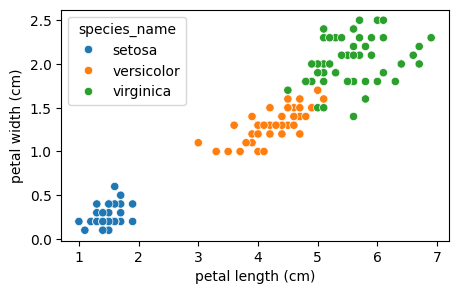

In [54]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [55]:
df = df.drop(columns=["species", "species_name"])

In [56]:
df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,-1
146,6.3,2.5,5.0,1.9,-1
147,6.5,3.0,5.2,2.0,-1
148,6.2,3.4,5.4,2.3,-1


# k-Means Algorithm

In [57]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [58]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [59]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
3,4.6,3.1,1.5,0.2
8,4.4,2.9,1.4,0.2
59,5.2,2.7,3.9,1.4


In [60]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
62,6.0,2.2,4.0,1.0
23,5.1,3.3,1.7,0.5
107,7.3,2.9,6.3,1.8


In [61]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False  # Return False at start of loop
    return np.allclose(old_centroids.values, new_centroids.values, atol=0.001)

In [62]:
def update_centroids(df):
    return df.groupby("current_cluster").mean()[df.columns[:-1]]


In [63]:
# plot data and centroids for each iteration
def plot_clusters(df, centroids, iteration):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "current_cluster");

    # Plot the centroids
    plt.scatter(
        centroids["petal length (cm)"], centroids["petal width (cm)"],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iteration}')
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)


In [64]:
def get_cluster(df, centroids, plot=True):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # keep track of what iteration we are on for plotting
    iteration = 0
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df


In [65]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
42,4.4,3.2,1.3,0.2
125,7.2,3.2,6.0,1.8
66,5.6,3.0,4.5,1.5


In [66]:
get_cluster(df, get_random_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Inertia Method

In [67]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

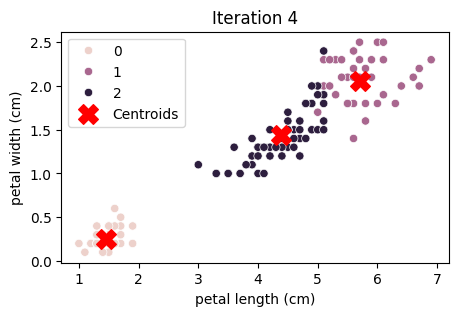

In [68]:
clustered_df = get_cluster(df, get_random_centroids(df, 3))

In [69]:
inertia = get_inertia(clustered_df, update_centroids(clustered_df))
inertia

78.85566582597727

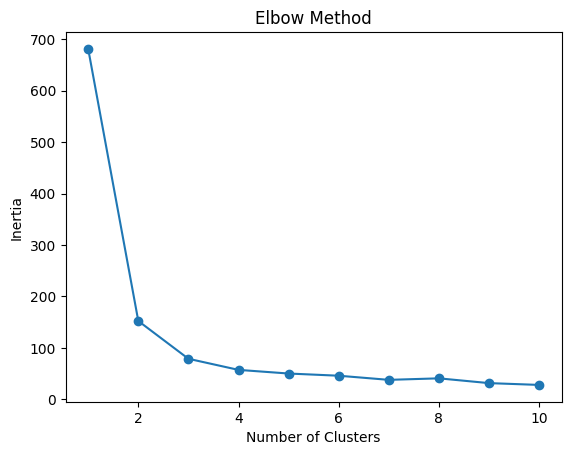

In [71]:
inertias = []
for i in range(1, 11):
    centroids = get_random_centroids(df, i)
    clustered_df = get_cluster(df, centroids, plot=False)
    inertia = get_inertia(clustered_df, update_centroids(clustered_df))
    inertias.append(inertia)


plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Initialize Centroids

In [27]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])

In [28]:
get_cluster(df, initialize_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


# Silhouette Coefficients

In [19]:
def mean_intra_cluster_distance(df, cluster):
    cluster_distances = []
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == cluster]
    for i in cluster_points.index:
        point = cluster_points.loc[i, df.columns[:-1]]



In [19]:
def mean_nearest_cluster_distance(df, point):
    distances = []
    for cluster in df['current_cluster'].unique():
        # get all points in the current cluster
        cluster_points = df[df['current_cluster'] == cluster]


In [ ]:
def get_silhouette_coefficient(df,